# GLM: Negative Binomial Regression

This notebook demos negative binomial regression using the `glm` submodule. It closely follows the GLM Poisson regression example by [Jonathan Sedar](https://github.com/jonsedar) (which is in turn insipired by [a project by Ian Osvald](http://ianozsvald.com/2016/05/07/statistically-solving-sneezes-and-sniffles-a-work-in-progress-report-at-pydatalondon-2016/)) except the data here is negative binomially distributed instead of Poisson distributed.

Negative binomial regression is used to model count data for which the variance is higher than the mean. The [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution) can be thought of as a Poisson distribution whose rate parameter is gamma distributed, so that rate parameter can be adjusted to account for the increased variance.

#### Contents

+ [Setup](#Setup)
    + [Convenience Functions](#Convenience-Functions)
    + [Generate Data](#Generate-Data)
        + [Poisson Data](#Poisson-Data)
        + [Negative Binomial Data](#Negative-Binomial-Data)
        + [Visualize the Data](#Visualize-the-Data)


+ [Negative Binomial Regression](#Negative-Binomial-Regression)
    + [Create GLM Model](#Create-GLM-Model)
    + [View Results](#View-Results)


## Setup

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

### Convenience Functions

Taken from the Poisson regression example.

In [2]:
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.df_summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
        
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

### Generate Data

As in the Poisson regression example, we assume that sneezing occurs at some baseline rate, and that consuming alcohol, not taking antihistamines, or doing both, increase its frequency.

#### Poisson Data

First, let's look at some Poisson distributed data from the Poisson regression example.

In [3]:
np.random.seed(123)

In [4]:
# Mean Poisson values
theta_noalcohol_meds = 1    # no alcohol, took an antihist
theta_alcohol_meds = 3      # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36   # alcohol, no antihist

# Create samples
q = 1000
df_pois = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(theta_noalcohol_meds, q),
                                   np.random.poisson(theta_alcohol_meds, q),
                                   np.random.poisson(theta_noalcohol_nomeds, q), 
                                   np.random.poisson(theta_alcohol_nomeds, q))),
        'alcohol': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'nomeds': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})

In [5]:
df_pois.groupby(['nomeds', 'alcohol'])['nsneeze'].agg(['mean', 'var'])

mean        var
nomeds alcohol                   
False  False     0.989   1.019899
       True      2.973   2.985256
True   False     5.948   5.907203
       True     36.163  39.493925

Since the mean and variance of a Poisson distributed random variable are equal, the sample means and variances are very close.

#### Negative Binomial Data

Now, suppose every subject in the dataset had the flu, increasing the variance of their sneezing (and causing an unfortunate few to sneeze over 70 times a day). If the mean number of sneezes stays the same but variance increases, the data might follow a negative binomial distribution.

In [6]:
# Gamma shape parameter
alpha = 10

def get_nb_vals(mu, alpha, size):
    """Generate negative binomially distributed samples by
    drawing a sample from a gamma distribution with mean `mu` and
    shape parameter `alpha', then drawing from a Poisson
    distribution whose rate parameter is given by the sampled
    gamma variable.

    """

    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)

# Create samples
n = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((get_nb_vals(theta_noalcohol_meds, alpha, n),
                                   get_nb_vals(theta_alcohol_meds, alpha, n),
                                   get_nb_vals(theta_noalcohol_nomeds, alpha, n),
                                   get_nb_vals(theta_alcohol_nomeds, alpha, n))),
        'alcohol': np.concatenate((np.repeat(False, n),
                                   np.repeat(True, n),
                                   np.repeat(False, n),
                                   np.repeat(True, n))),
        'nomeds': np.concatenate((np.repeat(False, n),
                                      np.repeat(False, n),
                                      np.repeat(True, n),
                                      np.repeat(True, n)))})

In [7]:
df.groupby(['nomeds', 'alcohol'])['nsneeze'].agg(['mean', 'var'])

mean         var
nomeds alcohol                    
False  False     0.976    1.106531
       True      2.961    3.619098
True   False     6.022    9.505021
       True     36.254  167.348833

As in the Poisson regression example, we see that drinking alcohol and/or not taking antihistamines increase the sneezing rate to varying degrees. Unlike in that example, for each combination of `alcohol` and `nomeds`, the variance of `nsneeze` is higher than the mean. This suggests that a Poisson distrubution would be a poor fit for the data since the mean and variance of a Poisson distribution are equal.

### Visualize the Data

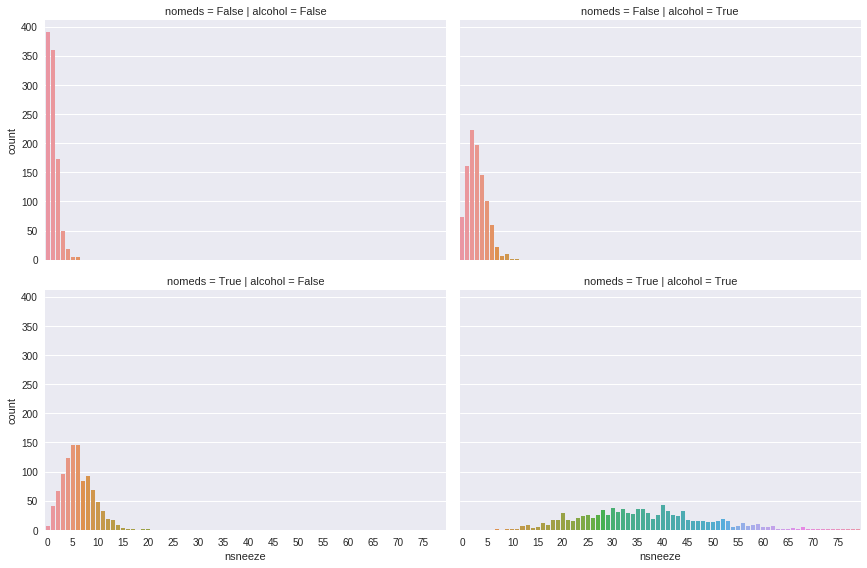

In [8]:
g = sns.factorplot(x='nsneeze', row='nomeds', col='alcohol', data=df, kind='count', aspect=1.5)

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which='both')))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);

## Negative Binomial Regression

### Create GLM Model

In [9]:
fml = 'nsneeze ~ alcohol + nomeds + alcohol:nomeds'

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=fml, data=df, family=pm.glm.families.NegativeBinomial())
    
    # Old initialization
    # start = pm.find_MAP(fmin=optimize.fmin_powell)
    # C = pm.approx_hessian(start)
    # trace = pm.sample(4000, step=pm.NUTS(scaling=C))
    
    trace = pm.sample(2000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 10,338:   7%|▋         | 13828/200000 [00:22<06:19, 490.54it/s]
Convergence archived at 13900
Interrupted at 13,900 [6%]: Average Loss = 14,046
100%|██████████| 2500/2500 [11:04<00:00,  2.93it/s]


### View Results

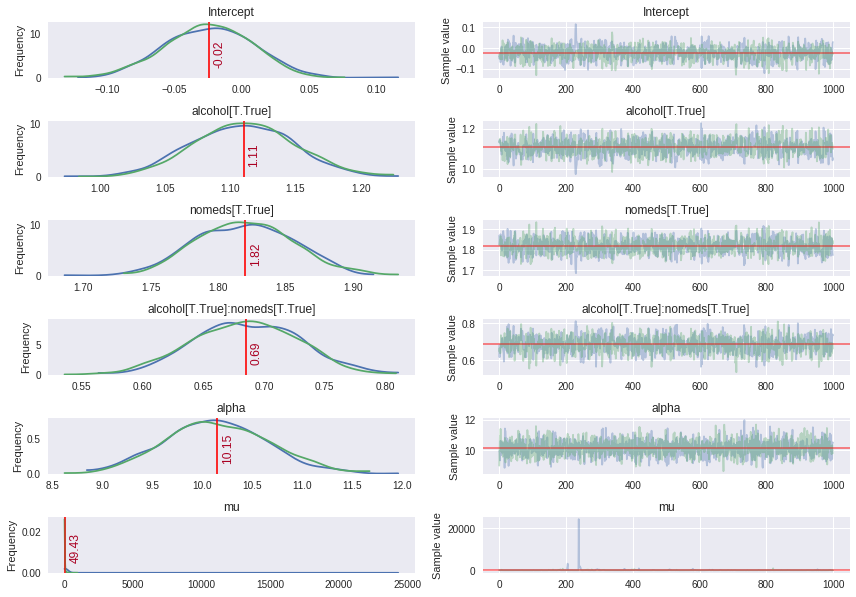

In [10]:
rvs = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
plot_traces(trace[1000:], varnames=rvs);

In [11]:
# Transform coefficients to recover parameter values
np.exp(pm.df_summary(trace[1000:], varnames=rvs)[['mean','hpd_2.5','hpd_97.5']])

,mean,hpd_2.5,hpd_97.5
Intercept,9.758611e-01,0.913428,1.032908e+00
alcohol[T.True],3.034905e+00,2.820879,3.267148e+00
nomeds[T.True],6.170180e+00,5.774109,6.613178e+00
alcohol[T.True]:nomeds[T.True],1.984273e+00,1.833042,2.161982e+00
alpha,2.548632e+04,9936.840573,7.110099e+04
mu,2.925866e+21,1.004314,1.691800e+54


The mean values are close to the values we specified when generating the data:
- The base rate is a constant 1.
- Drinking alcohol triples the base rate.
- Not taking antihistamines increases the base rate by 6 times.
- Drinking alcohol and not taking antihistamines doubles the rate that would be expected if their rates were independent. If they were independent, then doing both would increase the base rate by 3\*6=18 times, but instead the base rate is increased by 3\*6\*2=16 times.

Finally, even though the sample for `mu` is highly skewed, its median value is close to the sample mean, and the mean of `alpha` is also quite close to its actual value of 10.

In [12]:
np.percentile(trace[1000:]['mu'], [25,50,75])

array([  4.25400876,  11.2521235 ,  27.12410786])

In [13]:
df.nsneeze.mean()

11.55325

In [14]:
trace[1000:]['alpha'].mean()

10.145896982642357